# Апробация модели мультиэкспоненциального частотного скана на данных из набора "1564ЛЕ1 при разных U1 Ur август 2022"

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''

## 0. Импорт модулей

In [2]:
from os import listdir
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from fsmodels import SklMultiExpFrequencyScan, SklSingleExpFrequencyScan

from fsplots import plot_experimental_points
from fsplots import plot_spectr
from fsplots import plot_model
from fsplots import plot_loss_path
from fsplots import plot_deviations

%matplotlib inline

## 1. Чтение данных

In [3]:
DATASET_PATH = '../dataset/'
PLOTS_PATH = '../plots/'
MODELS_PATH = '../models/'

In [4]:
file_names = listdir(DATASET_PATH)

In [5]:
u1 = -4
ur = -5

data_frames = [[file_name, pd.read_csv(DATASET_PATH + file_name, parse_dates=[0])] for file_name in file_names]

condition = lambda frame: frame.loc[0, 'u1']==u1 and frame.loc[0, 'ur']==ur
data_frames = [[name, frame] for [name, frame] in data_frames if condition(frame)]

In [6]:
len(data_frames)

3

In [7]:
print(data_frames[0][0])
data_frames[0][1].head()

1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01.csv


,time,frequency_hz,dlts_v,temperature_k,dlts_pf,bs,ls,f_pulse,u1,ur,time_between_meas,integral_time,specimen_name
0,2022-08-04 15:21:09,2500.0000,3.122,283.194,0.001561,1,50,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
1,2022-08-04 15:21:13,2443.0925,3.187,283.187,0.001593,1,50,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
2,2022-08-04 15:21:17,2387.4812,3.201,283.191,0.001600,1,50,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
3,2022-08-04 15:21:21,2333.1355,3.259,283.206,0.001629,1,50,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
4,2022-08-04 15:21:25,2280.0269,3.271,283.199,0.001636,1,50,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1


In [8]:
data_frames[0][1].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   time               340 non-null    datetime64[ns]
 1   frequency_hz       340 non-null    float64       
 2   dlts_v             340 non-null    float64       
 3   temperature_k      340 non-null    float64       
 4   dlts_pf            340 non-null    float64       
 5   bs                 340 non-null    int64         
 6   ls                 340 non-null    int64         
 7   f_pulse            340 non-null    float64       
 8   u1                 340 non-null    float64       
 9   ur                 340 non-null    float64       
 10  time_between_meas  340 non-null    float64       
 11  integral_time      340 non-null    float64       
 12  specimen_name      340 non-null    object        
dtypes: datetime64[ns](1), float64(9), int64(2), object(1)
memory usag

In [9]:
print(data_frames[1][0])
data_frames[1][1].head()

1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1.csv


,time,frequency_hz,dlts_v,temperature_k,dlts_pf,bs,ls,f_pulse,u1,ur,time_between_meas,integral_time,specimen_name
0,2022-08-03 14:34:48,2500.0000,1.456,303.264,0.007280,10,50,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
1,2022-08-03 14:34:52,1985.8207,1.526,303.276,0.007630,10,50,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
2,2022-08-03 14:34:56,1577.3937,1.649,303.279,0.008245,10,50,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
3,2022-08-03 14:35:00,1252.9686,1.755,303.281,0.008775,10,50,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
4,2022-08-03 14:35:03,995.2686,1.907,303.281,0.009535,10,50,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1


In [10]:
data_frames[1][1].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   time               34 non-null     datetime64[ns]
 1   frequency_hz       34 non-null     float64       
 2   dlts_v             34 non-null     float64       
 3   temperature_k      34 non-null     float64       
 4   dlts_pf            34 non-null     float64       
 5   bs                 34 non-null     int64         
 6   ls                 34 non-null     int64         
 7   f_pulse            34 non-null     float64       
 8   u1                 34 non-null     float64       
 9   ur                 34 non-null     float64       
 10  time_between_meas  34 non-null     float64       
 11  integral_time      34 non-null     float64       
 12  specimen_name      34 non-null     object        
dtypes: datetime64[ns](1), float64(9), int64(2), object(1)
memory usage:

In [11]:
print(data_frames[2][0])
data_frames[2][1].head()

1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01.csv


,time,frequency_hz,dlts_v,temperature_k,dlts_pf,bs,ls,f_pulse,u1,ur,time_between_meas,integral_time,specimen_name
0,2022-08-02 17:55:01,2500.0000,5.276,262.940,0.000528,1,10,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
1,2022-08-02 17:55:05,2443.0925,5.449,262.941,0.000545,1,10,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
2,2022-08-02 17:55:09,2387.4812,5.855,262.941,0.000585,1,10,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
3,2022-08-02 17:55:13,2333.1355,6.665,262.940,0.000666,1,10,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
4,2022-08-02 17:55:17,2280.0269,6.626,262.936,0.000663,1,10,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1


In [12]:
data_frames[2][1].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   time               340 non-null    datetime64[ns]
 1   frequency_hz       340 non-null    float64       
 2   dlts_v             340 non-null    float64       
 3   temperature_k      340 non-null    float64       
 4   dlts_pf            340 non-null    float64       
 5   bs                 340 non-null    int64         
 6   ls                 340 non-null    int64         
 7   f_pulse            340 non-null    float64       
 8   u1                 340 non-null    float64       
 9   ur                 340 non-null    float64       
 10  time_between_meas  340 non-null    float64       
 11  integral_time      340 non-null    float64       
 12  specimen_name      340 non-null    object        
dtypes: datetime64[ns](1), float64(9), int64(2), object(1)
memory usag

## 2. 1564ЛЕ1№1\_п1\_2500Гц-1Гц\_10пФ\_+30С\_-4В-5В\_50мВ\_10мкс\_шаг\_0,1.csv
### 2.1. Подготовка экспериментальных данных

In [13]:
def get_X_y(dataset):
    filling_pulse = dataset.f_pulse[0] * 10 ** -6
    X_train = np.log10(dataset.frequency_hz.to_numpy())
    y_train = dataset.dlts_pf.to_numpy()
    
    return filling_pulse, X_train, y_train

In [14]:
filling_pulse, X_train, y_train = get_X_y(data_frames[0][1])

In [15]:
normalize = lambda X, y: (X.max() / y.max(), y * X.max() / y.max())
denormalize = lambda X, y_normalized: y_normalized * y_normalized.max() / X.max()

In [16]:
k, y_train = normalize(X_train, y_train)
k

835.2851545408156

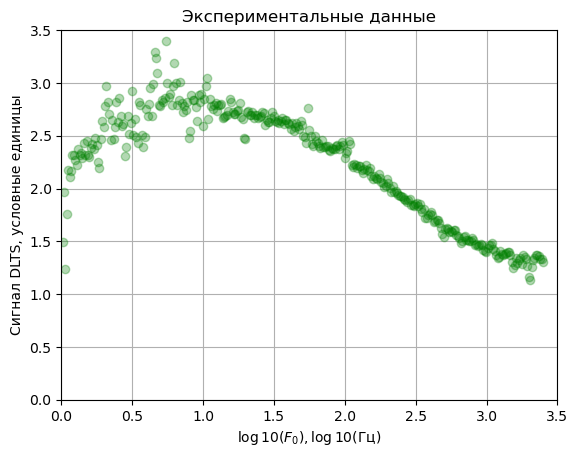

In [17]:
fig, ax = plot_experimental_points(X_train, y_train)
ax.set_ylim([0, 3.5])
ax.set_xlim([0, 3.5])
plt.show()

### 2.2. Идентификация моноэкспоненциальной модели с показателем $p$

In [18]:
monoexp_fs = SklSingleExpFrequencyScan(filling_pulse = filling_pulse,
                                       learning_rate = 0.05,
                                       stop_val = 10**-5,
                                       verbose = False
                                      )

monoexp_fs.fit(X = X_train, y = y_train)
monoexp_fs.fit_results_

2022-09-23 20:33:45.793488: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-09-23 20:33:45.793529: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: aleksei-B550I
2022-09-23 20:33:45.793533: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: aleksei-B550I
2022-09-23 20:33:45.793799: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-09-23 20:33:45.793821: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-09-23 20:33:45.793824: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.65.1
2022-09-23 20:33:45.794808: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instru

,amplitude_0,filling_pulse,fit_p_coef,learning_rate,loss,n_exps,n_iters,p_coef,stop_val,time_constant_pow_0,verbose
0,-0.310894,0.00001,True,0.05,5.932200,1,1000,1.000000,0.00001,-1.611299,False
1,-0.202609,0.00001,True,0.05,5.697347,1,1000,1.015878,0.00001,-1.615591,False
2,-0.098060,0.00001,True,0.05,5.480583,1,1000,1.025854,0.00001,-1.618406,False
3,0.003221,0.00001,True,0.05,5.278115,1,1000,1.030548,0.00001,-1.619773,False
4,0.101622,0.00001,True,0.05,5.086964,1,1000,1.030397,0.00001,-1.619728,False
...,...,...,...,...,...,...,...,...,...,...,...
136,2.877344,0.00001,True,0.05,0.018107,1,1000,0.172617,0.00001,-1.263294,False
137,2.878118,0.00001,True,0.05,0.018095,1,1000,0.172741,0.00001,-1.263352,False
138,2.878865,0.00001,True,0.05,0.018084,1,1000,0.172861,0.00001,-1.263412,False
139,2.879588,0.00001,True,0.05,0.018073,1,1000,0.172977,0.00001,-1.263472,False


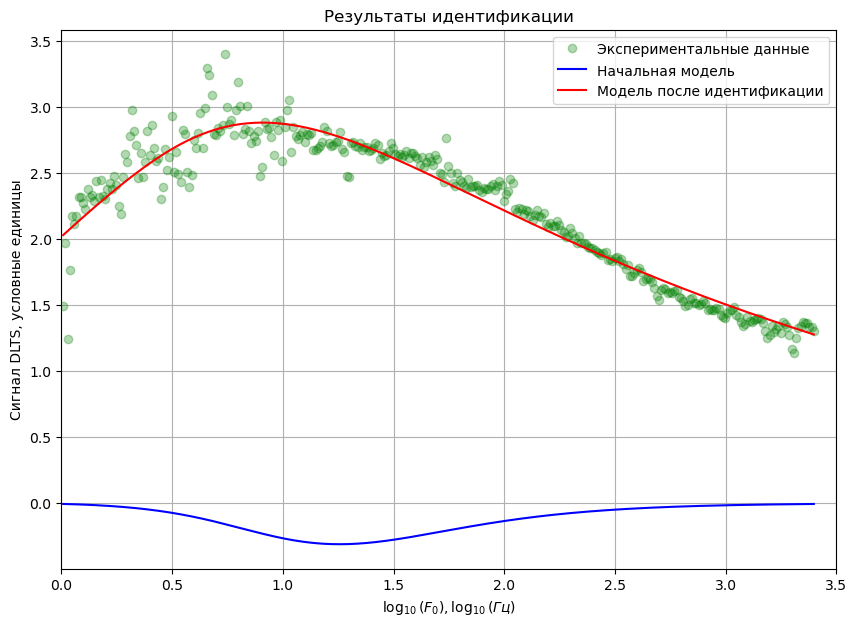

In [19]:
fig, ax = plot_model(X_train, y_train, SklSingleExpFrequencyScan, monoexp_fs.fit_results_, plot_exps=False)
plt.show()

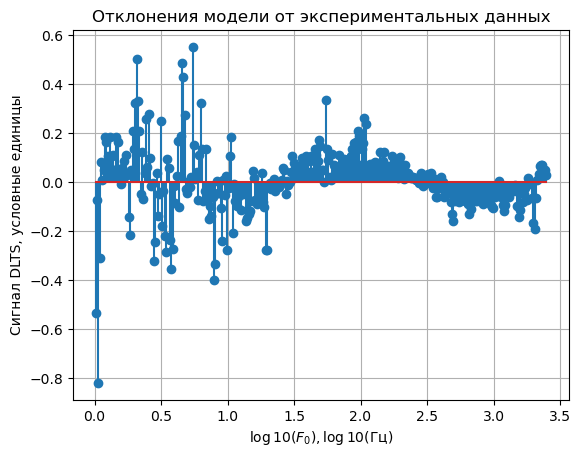

In [20]:
plot_deviations(X_train, y_train, monoexp_fs.predict(X_train))
plt.show()

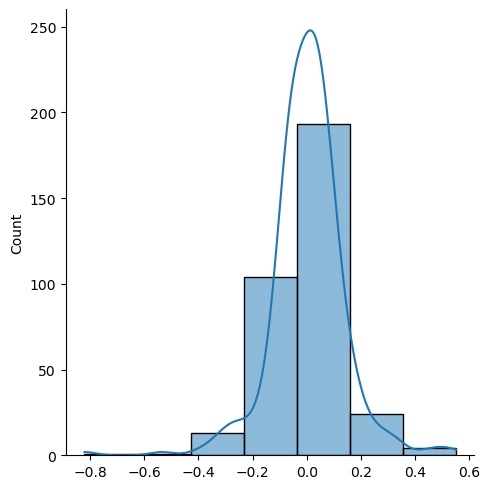

In [21]:
sns.displot(x=y_train - monoexp_fs.predict(X_train), bins=7, kde=True)
plt.grid()
plt.show()

In [22]:
mean_squared_error(y_train, y_train - monoexp_fs.predict(X_train), squared=False)

2.286357621341597

### 2.3. Идентификация мультиэкспоненциальной модели с n_exps=1

In [23]:
multiexp_fs = SklMultiExpFrequencyScan(n_exps = 1,
                                       filling_pulse = filling_pulse,
                                       stop_val = 10**-5,
                                       learning_rate=0.05,
                                      )

multiexp_fs.fit(X=X_train, y=y_train)

SklMultiExpFrequencyScan(filling_pulse=9.999999999999999e-06,
                         learning_rate=0.05, stop_val=1e-05)

In [24]:
multiexp_fs.fit_results_

,amplitude_0,filling_pulse,learning_rate,loss,n_exps,n_iters,stop_val,time_constant_pow_0,verbose
0,-0.139934,0.00001,0.05,5.568766,1,1000,0.00001,-1.634368,False
1,-0.036498,0.00001,0.05,5.357591,1,1000,0.00001,-1.636423,False
2,0.064173,0.00001,0.05,5.157588,1,1000,0.00001,-1.636962,False
3,0.162174,0.00001,0.05,4.967999,1,1000,0.00001,-1.636014,False
4,0.257597,0.00001,0.05,4.788115,1,1000,0.00001,-1.633624,False
...,...,...,...,...,...,...,...,...,...
185,3.831680,0.00001,0.05,1.345588,1,1000,0.00001,-1.340012,False
186,3.832434,0.00001,0.05,1.345577,1,1000,0.00001,-1.340011,False
187,3.833167,0.00001,0.05,1.345566,1,1000,0.00001,-1.340009,False
188,3.833881,0.00001,0.05,1.345556,1,1000,0.00001,-1.340008,False


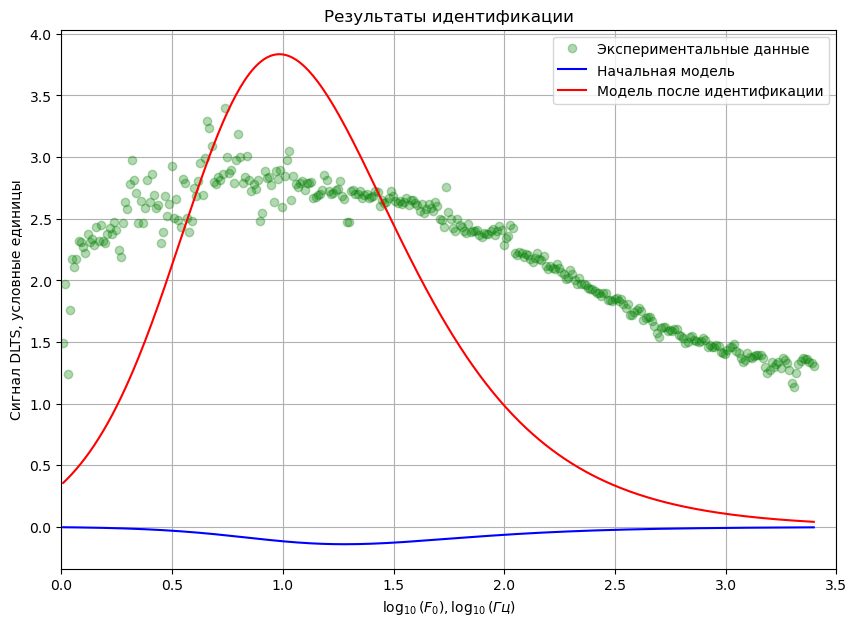

In [25]:
fig, ax = plot_model(X_train, y_train, SklMultiExpFrequencyScan, multiexp_fs.fit_results_, plot_exps=False)
plt.show()

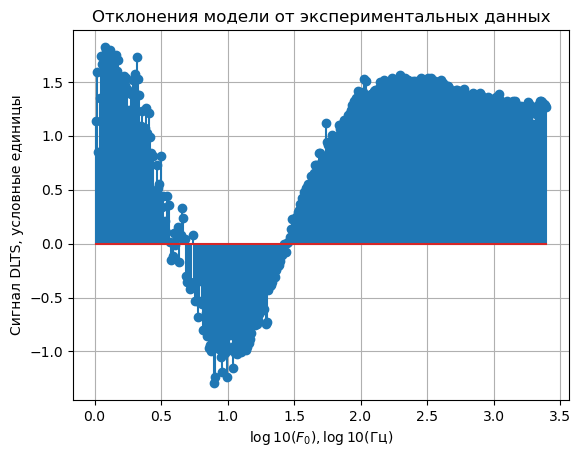

In [26]:
plot_deviations(X_train, y_train, multiexp_fs.predict(X_train))
plt.show()

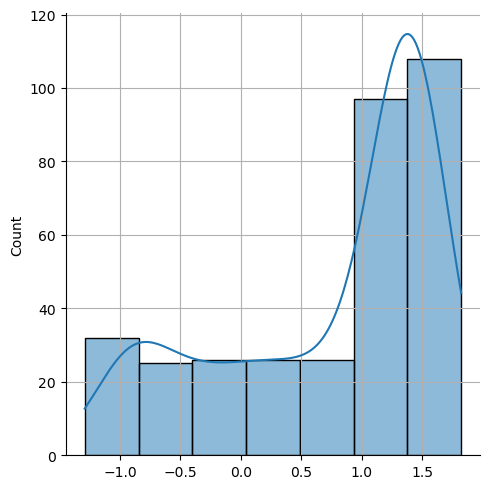

In [27]:
sns.displot(x=y_train - multiexp_fs.predict(X_train), bins=7, kde=True)
plt.grid()
plt.show()

In [28]:
def display_scores(scores):
    print(f'Scores: {scores}')
    print(f'Mean: {scores.mean()}')
    print(f'Standard deviation: {scores.std()}')

In [29]:
scores = cross_val_score(multiexp_fs, X_train, y_train, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)

display_scores(np.sqrt(-scores))

2022-09-23 20:34:32.576644: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-09-23 20:34:32.576669: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: aleksei-B550I
2022-09-23 20:34:32.576673: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: aleksei-B550I
2022-09-23 20:34:32.576796: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-09-23 20:34:32.576813: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-09-23 20:34:32.576818: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.65.1
2022-09-23 20:34:32.576999: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instru

Scores: [1.42342755 2.14388536 2.36579476]
Mean: 1.9777025564778041
Standard deviation: 0.4022656931726127


In [30]:
mean_squared_error(y_train, multiexp_fs.predict(X_train), squared=False)

1.159976954787796

### 2.4. Идентификация мультиэкспоненциальной модели с n_exps>1

In [31]:
multiexp_fs = SklMultiExpFrequencyScan(n_exps = 1,
                                       filling_pulse = filling_pulse,
                                       learning_rate = 0.05,
                                       stop_val = 10**-5
                                      )

In [32]:
param_grid = {'n_exps': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
grid_search = GridSearchCV(multiexp_fs, param_grid, cv=3, 
                           scoring='neg_mean_squared_error',
                           return_train_score=True, n_jobs=-1)

In [33]:
grid_search.fit(X_train, y_train)

2022-09-23 20:34:58.602355: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-09-23 20:34:58.602509: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: aleksei-B550I
2022-09-23 20:34:58.602519: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: aleksei-B550I
2022-09-23 20:34:58.602784: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-09-23 20:34:58.602830: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-09-23 20:34:58.602855: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.65.1
2022-09-23 20:34:58.603082: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instru

GridSearchCV(cv=3,
             estimator=SklMultiExpFrequencyScan(filling_pulse=9.999999999999999e-06,
                                                learning_rate=0.05,
                                                stop_val=1e-05),
             n_jobs=-1, param_grid={'n_exps': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [34]:
grid_search.best_params_

{'n_exps': 8}

In [35]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

1.8500602664513768 {'n_exps': 1}
1.5208795856051727 {'n_exps': 2}
1.0439900353725262 {'n_exps': 3}
0.9981146256705375 {'n_exps': 4}
1.0954284203090692 {'n_exps': 5}
1.0892046148662515 {'n_exps': 6}
1.0254213405665151 {'n_exps': 7}
0.823104143936978 {'n_exps': 8}
1.1087965591210216 {'n_exps': 9}
1.0003185026811974 {'n_exps': 10}


In [36]:
y_pred = grid_search.best_estimator_.predict(X_train)

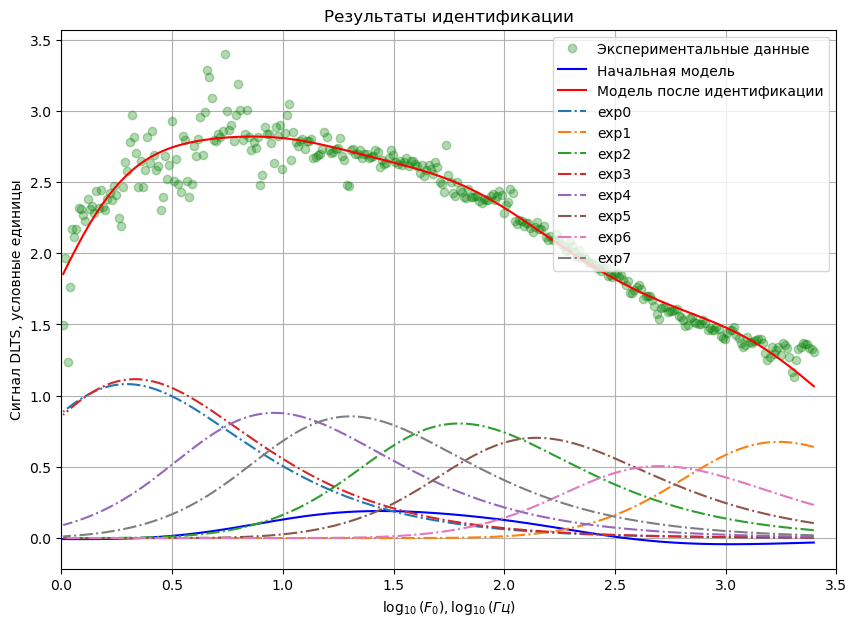

In [37]:
fig, ax = plot_model(X_train, y_train, SklMultiExpFrequencyScan, grid_search.best_estimator_.fit_results_)

plt.show()

In [38]:
grid_search.best_estimator_.fit_results_

,amplitude_0,amplitude_1,amplitude_2,amplitude_3,amplitude_4,amplitude_5,amplitude_6,amplitude_7,filling_pulse,learning_rate,...,stop_val,time_constant_pow_0,time_constant_pow_1,time_constant_pow_2,time_constant_pow_3,time_constant_pow_4,time_constant_pow_5,time_constant_pow_6,time_constant_pow_7,verbose
0,-0.043612,-0.031119,0.041366,0.030653,0.069413,0.053981,-0.071669,0.091595,0.00001,0.05,...,0.00001,-1.002079,-3.322948,-2.142026,-1.164903,-1.587493,-2.661144,-2.965153,-1.720520,False
1,0.050720,0.013487,0.125553,0.127877,0.164861,0.123397,-0.012752,0.184874,0.00001,0.05,...,0.00001,-1.000941,-3.324329,-2.140998,-1.165209,-1.586487,-2.659381,-2.967849,-1.718869,False
2,0.135551,0.053242,0.198935,0.214614,0.248517,0.184357,0.039199,0.266369,0.00001,0.05,...,0.00001,-1.001921,-3.323812,-2.138339,-1.165788,-1.583982,-2.655987,-2.968257,-1.715662,False
3,0.211968,0.088814,0.262854,0.292031,0.321772,0.237943,0.085128,0.337490,0.00001,0.05,...,0.00001,-1.003704,-3.322055,-2.134792,-1.165734,-1.580083,-2.651750,-2.967197,-1.711229,False
4,0.280873,0.120759,0.318464,0.361142,0.385845,0.285075,0.125824,0.399464,0.00001,0.05,...,0.00001,-1.005326,-3.319540,-2.130897,-1.164456,-1.574931,-2.647231,-2.965267,-1.705858,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269,1.081387,0.674216,0.804459,1.115997,0.878932,0.703580,0.505342,0.854621,0.00001,0.05,...,0.00001,-0.650465,-3.612645,-2.152288,-0.686813,-1.317178,-2.503579,-3.064961,-1.661028,False
270,1.081364,0.674566,0.804519,1.115974,0.878973,0.703667,0.505349,0.854622,0.00001,0.05,...,0.00001,-0.650454,-3.613230,-2.152428,-0.686811,-1.317174,-2.503551,-3.064976,-1.660959,False
271,1.081340,0.674915,0.804579,1.115950,0.879013,0.703753,0.505356,0.854623,0.00001,0.05,...,0.00001,-0.650442,-3.613812,-2.152567,-0.686810,-1.317170,-2.503523,-3.064989,-1.660888,False
272,1.081317,0.675261,0.804638,1.115927,0.879053,0.703838,0.505364,0.854624,0.00001,0.05,...,0.00001,-0.650431,-3.614392,-2.152705,-0.686808,-1.317166,-2.503496,-3.065002,-1.660818,False


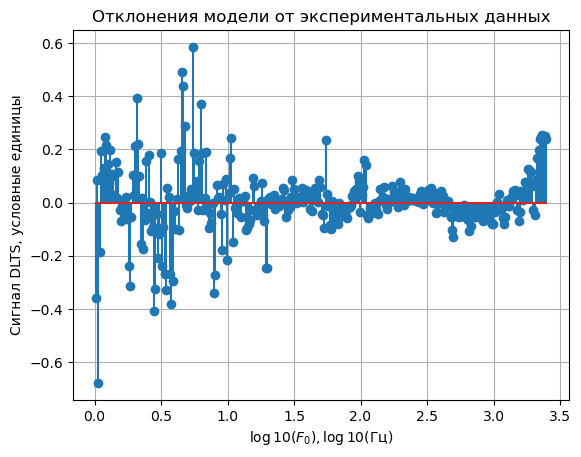

In [39]:
plot_deviations(X_train, y_train, y_pred)
plt.show()

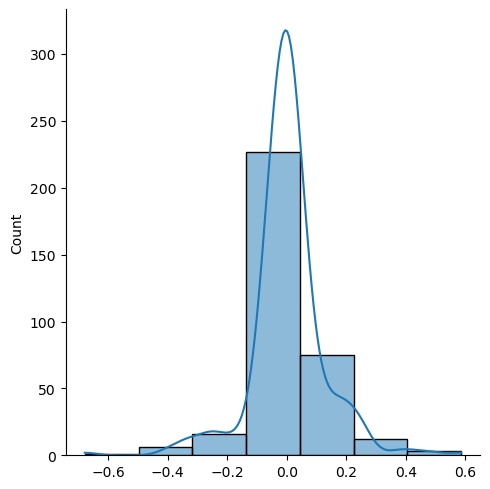

In [40]:
sns.displot(x=y_train - y_pred, bins=7, kde=True)
plt.show()

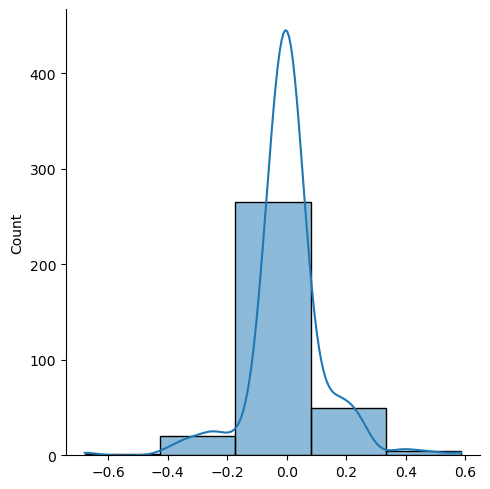

In [41]:
sns.displot(x=y_train - y_pred, bins=5, kde=True)
plt.show()

In [42]:
exps_params_303 = grid_search.best_estimator_.exps_params_
exps_params_303[:, 1] = exps_params_303[:, 1] / k

## 3. 1564ЛЕ1№1\_п1\_2500Гц-1Гц\_1пФ\_+10С\_-4В-5В\_50мВ\_10мкс\_шаг\_0,01.csv
### 3.1. Подготовка экспериментальных данных

In [43]:
filling_pulse, X_train, y_train = get_X_y(data_frames[1][1])

In [44]:
k, y_train = normalize(X_train, y_train)
k

180.3577499295137

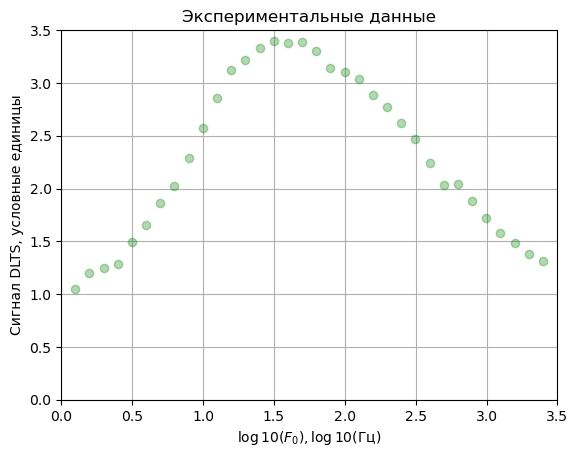

In [45]:
fig, ax = plot_experimental_points(X_train, y_train)
ax.set_ylim([0, 3.5])
ax.set_xlim([0, 3.5])
plt.show()

### 3.2. Идентификация моноэкспоненциальной модели с показателем $p$

In [46]:
monoexp_fs = SklSingleExpFrequencyScan(filling_pulse = filling_pulse,
                                       learning_rate = 0.05,
                                       stop_val = 10**-5,
                                       verbose = False
                                      )

monoexp_fs.fit(X = X_train, y = y_train)
monoexp_fs.fit_results_

,amplitude_0,filling_pulse,fit_p_coef,learning_rate,loss,n_exps,n_iters,p_coef,stop_val,time_constant_pow_0,verbose
0,0.561938,0.00001,True,0.05,4.708503,1,1000,1.000000,0.00001,-1.826922,False
1,0.660861,0.00001,True,0.05,4.499669,1,1000,0.974706,0.00001,-1.832378,False
2,0.758234,0.00001,True,0.05,4.290928,1,1000,0.944579,0.00001,-1.838395,False
3,0.854246,0.00001,True,0.05,4.080164,1,1000,0.909378,0.00001,-1.844775,False
4,0.949086,0.00001,True,0.05,3.864955,1,1000,0.868755,0.00001,-1.851310,False
...,...,...,...,...,...,...,...,...,...,...,...
150,3.337082,0.00001,True,0.05,0.014219,1,1000,0.275187,0.00001,-1.920401,False
151,3.337836,0.00001,True,0.05,0.014207,1,1000,0.275314,0.00001,-1.920377,False
152,3.338569,0.00001,True,0.05,0.014196,1,1000,0.275438,0.00001,-1.920354,False
153,3.339282,0.00001,True,0.05,0.014186,1,1000,0.275559,0.00001,-1.920332,False


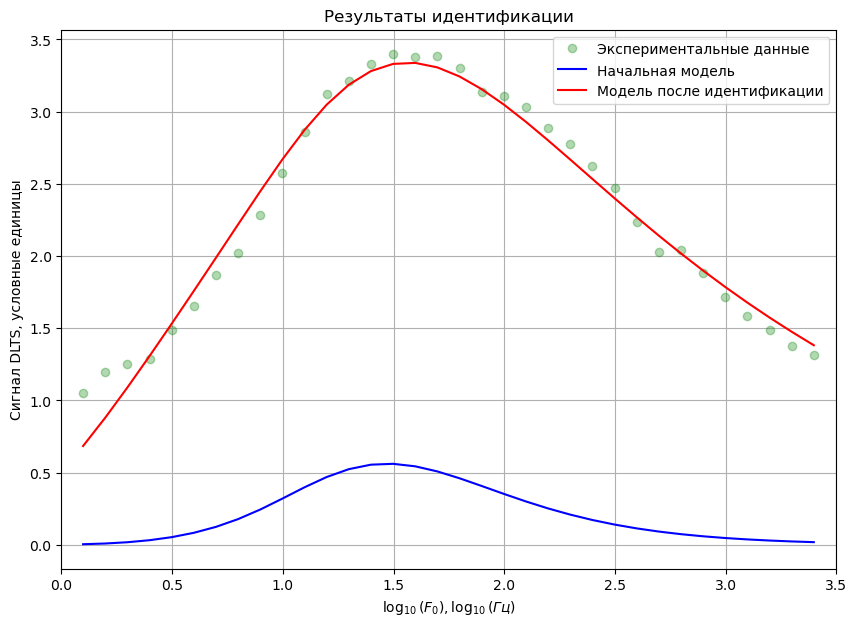

In [47]:
fig, ax = plot_model(X_train, y_train, SklSingleExpFrequencyScan, monoexp_fs.fit_results_, plot_exps=False)
plt.show()

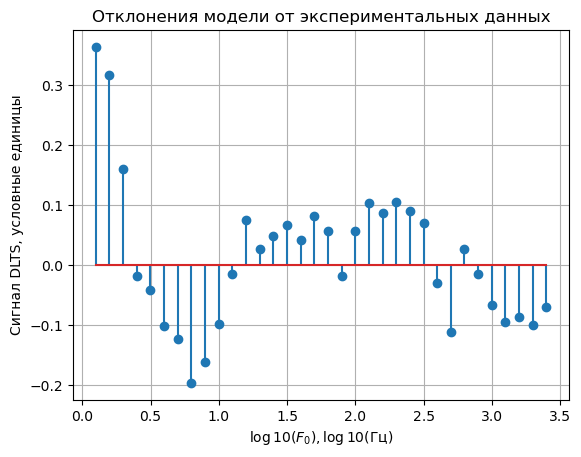

In [48]:
plot_deviations(X_train, y_train, monoexp_fs.predict(X_train))
plt.show()

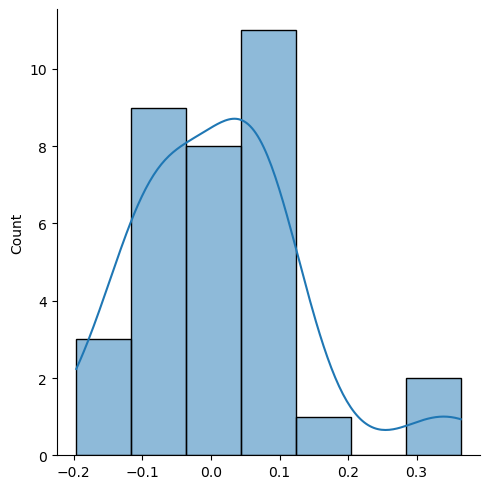

In [49]:
sns.displot(x=y_train - monoexp_fs.predict(X_train), bins=7, kde=True)
plt.show()

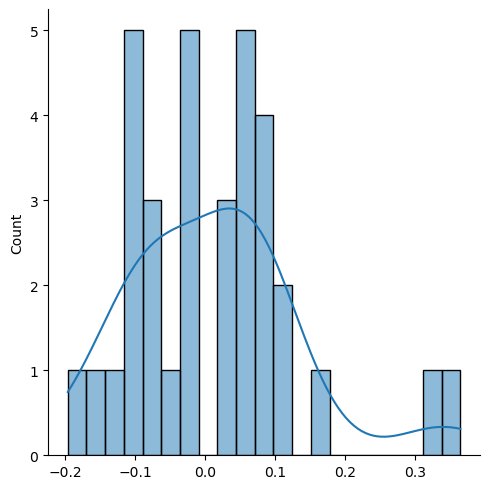

In [50]:
sns.displot(x=y_train - monoexp_fs.predict(X_train), bins=5, kde=True)
plt.grid()
plt.show()

In [51]:
mean_squared_error(y_train, y_train - monoexp_fs.predict(X_train), squared=False)

2.417552958855534

### 3.3. Идентификация мультиэкспоненциальной модели с n_exps=1

In [52]:
multiexp_fs = SklMultiExpFrequencyScan(n_exps = 1,
                                       filling_pulse = filling_pulse,
                                       stop_val = 10**-5,
                                       learning_rate=0.05,
                                      )

multiexp_fs.fit(X=X_train, y=y_train)

SklMultiExpFrequencyScan(filling_pulse=9.999999999999999e-06,
                         learning_rate=0.05, stop_val=1e-05)

In [53]:
multiexp_fs.fit_results_

,amplitude_0,filling_pulse,learning_rate,loss,n_exps,n_iters,stop_val,time_constant_pow_0,verbose
0,-0.729326,0.00001,0.05,6.895050,1,1000,0.00001,-3.263732,False
1,-0.652895,0.00001,0.05,6.739613,1,1000,0.00001,-3.311662,False
2,-0.581478,0.00001,0.05,6.606631,1,1000,0.00001,-3.354810,False
3,-0.514607,0.00001,0.05,6.492787,1,1000,0.00001,-3.393339,False
4,-0.451826,0.00001,0.05,6.395116,1,1000,0.00001,-3.427434,False
...,...,...,...,...,...,...,...,...,...
217,4.296260,0.00001,0.05,0.961446,1,1000,0.00001,-1.931470,False
218,4.297027,0.00001,0.05,0.961435,1,1000,0.00001,-1.931471,False
219,4.297775,0.00001,0.05,0.961424,1,1000,0.00001,-1.931472,False
220,4.298502,0.00001,0.05,0.961413,1,1000,0.00001,-1.931473,False


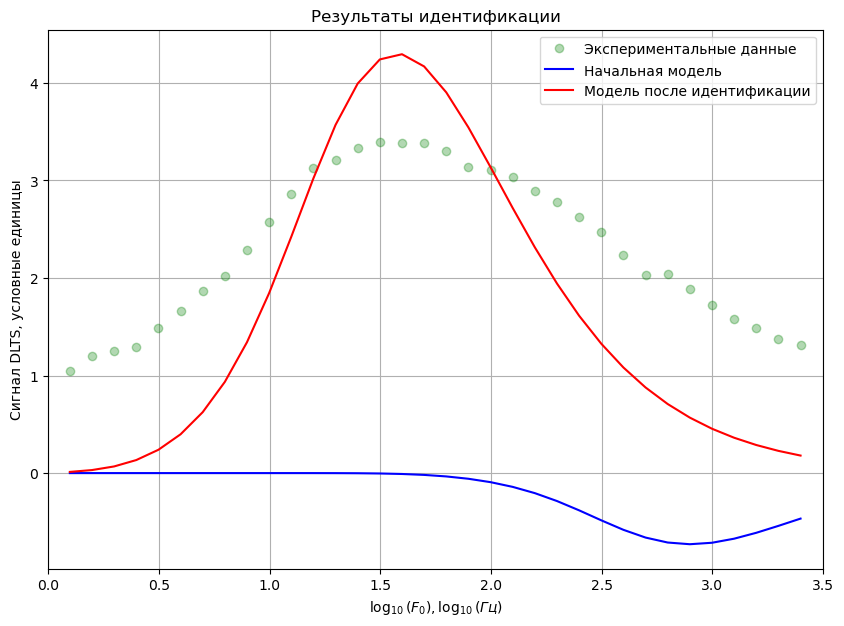

In [54]:
fig, ax = plot_model(X_train, y_train, SklMultiExpFrequencyScan, multiexp_fs.fit_results_, plot_exps=False)
plt.show()

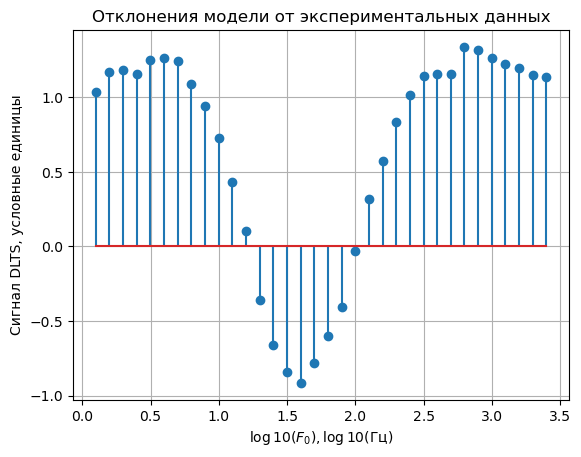

In [55]:
plot_deviations(X_train, y_train, multiexp_fs.predict(X_train))
plt.show()

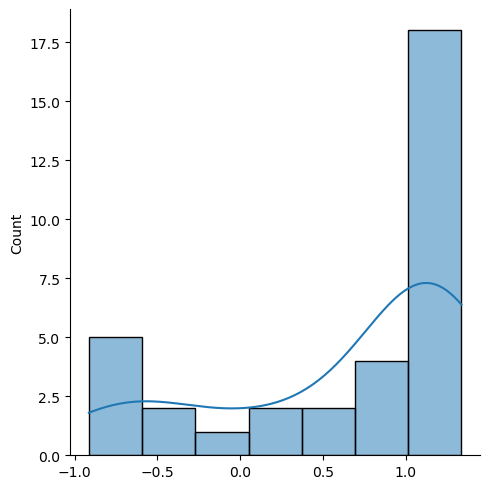

In [56]:
sns.displot(x=y_train - multiexp_fs.predict(X_train), bins=7, kde=True)
plt.grid()
plt.show()

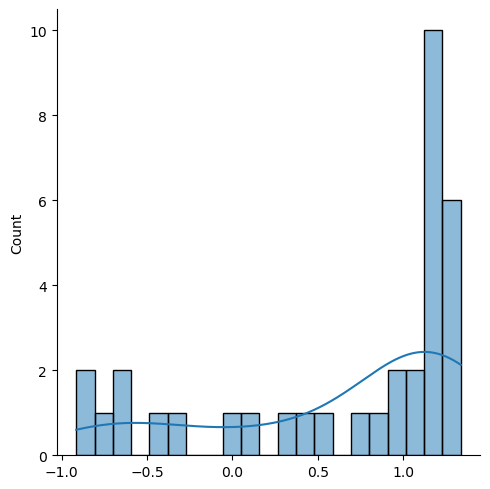

In [57]:
sns.displot(x=y_train - multiexp_fs.predict(X_train), bins=5, kde=True)
plt.show()

In [58]:
scores = cross_val_score(multiexp_fs, X_train, y_train, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)

display_scores(np.sqrt(-scores))

2022-09-23 21:07:25.424826: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-09-23 21:07:25.424850: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: aleksei-B550I
2022-09-23 21:07:25.424854: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: aleksei-B550I
2022-09-23 21:07:25.424998: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-09-23 21:07:25.425011: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-09-23 21:07:25.425015: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.65.1
2022-09-23 21:07:25.425174: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instru

Scores: [1.42488746 2.55677209 1.46121033]
Mean: 1.8142899603818836
Standard deviation: 0.5252235243983548


In [59]:
mean_squared_error(y_train, multiexp_fs.predict(X_train), squared=False)

0.9805116818266475

### 3.4. Идентификация мультиэкспоненциальной модели с n_exps>1

In [60]:
multiexp_fs = SklMultiExpFrequencyScan(n_exps = 1,
                                       filling_pulse = filling_pulse,
                                       learning_rate = 0.05,
                                       stop_val = 10**-5
                                      )

In [61]:
param_grid = {'n_exps': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
grid_search = GridSearchCV(multiexp_fs, param_grid, cv=3, 
                           scoring='neg_mean_squared_error',
                           return_train_score=True, n_jobs=-1)

In [62]:
grid_search.fit(X_train, y_train)

2022-09-23 21:07:53.206949: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-09-23 21:07:53.207177: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: aleksei-B550I
2022-09-23 21:07:53.207187: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: aleksei-B550I
2022-09-23 21:07:53.207579: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-09-23 21:07:53.207636: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-09-23 21:07:53.207671: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.65.1
2022-09-23 21:07:53.208013: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instru

2022-09-23 21:07:53.414710: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-09-23 21:07:53.414746: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: aleksei-B550I
2022-09-23 21:07:53.414754: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: aleksei-B550I
2022-09-23 21:07:53.414971: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-09-23 21:07:53.414999: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-09-23 21:07:53.415006: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.65.1
2022-09-23 21:07:53.415213: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instru

GridSearchCV(cv=3,
             estimator=SklMultiExpFrequencyScan(filling_pulse=9.999999999999999e-06,
                                                learning_rate=0.05,
                                                stop_val=1e-05),
             n_jobs=-1, param_grid={'n_exps': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [63]:
grid_search.best_params_

{'n_exps': 8}

In [64]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

1.8887082801631718 {'n_exps': 1}
1.2436980659343049 {'n_exps': 2}
0.76354682357085 {'n_exps': 3}
0.6183372471119511 {'n_exps': 4}
0.6328267724197111 {'n_exps': 5}
0.5678448793005086 {'n_exps': 6}
0.516315115546934 {'n_exps': 7}
0.4684499747748683 {'n_exps': 8}
0.5466099719154236 {'n_exps': 9}
0.537764952272324 {'n_exps': 10}


In [65]:
y_pred = grid_search.best_estimator_.predict(X_train)

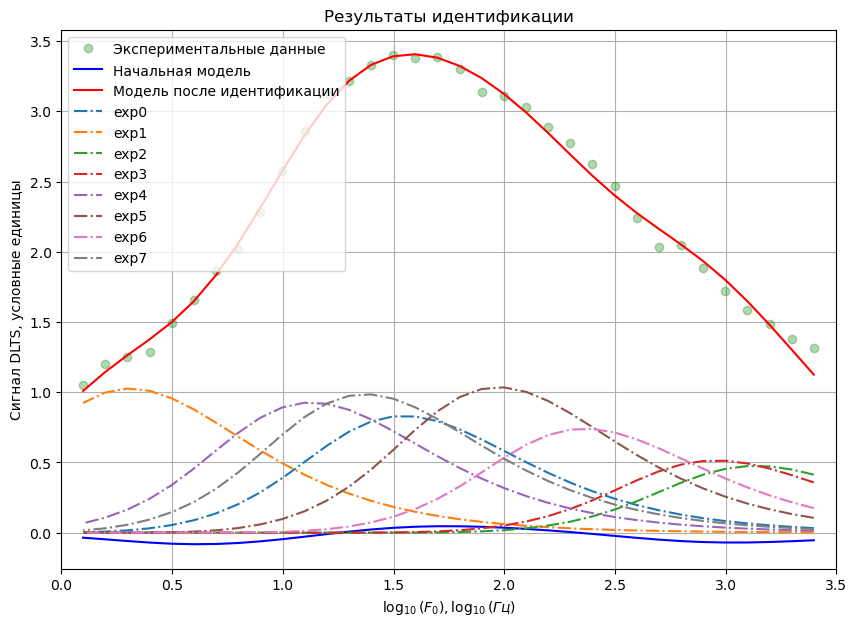

In [67]:
fig, ax = plot_model(X_train, y_train, SklMultiExpFrequencyScan, grid_search.best_estimator_.fit_results_)

plt.show()

In [68]:
grid_search.best_estimator_.fit_results_

,amplitude_0,amplitude_1,amplitude_2,amplitude_3,amplitude_4,amplitude_5,amplitude_6,amplitude_7,filling_pulse,learning_rate,...,stop_val,time_constant_pow_0,time_constant_pow_1,time_constant_pow_2,time_constant_pow_3,time_constant_pow_4,time_constant_pow_5,time_constant_pow_6,time_constant_pow_7,verbose
0,-0.074551,-0.092405,-0.058993,-0.007402,-0.006553,0.079363,-0.012816,0.077756,0.00001,0.05,...,0.00001,-1.860749,-1.061765,-3.397958,-3.357349,-1.662059,-2.004717,-3.094464,-1.780749,False
1,0.039298,-0.008083,-0.006190,0.047851,0.104489,0.193008,0.057948,0.190907,0.00001,0.05,...,0.00001,-1.860380,-1.056184,-3.401625,-3.357807,-1.661908,-2.004089,-3.095214,-1.781706,False
2,0.139129,0.066442,0.040749,0.097169,0.201759,0.292896,0.121230,0.290067,0.00001,0.05,...,0.00001,-1.860598,-1.055771,-3.401971,-3.355144,-1.663997,-2.003142,-3.092157,-1.783873,False
3,0.226642,0.132651,0.082663,0.141372,0.286975,0.380680,0.178058,0.376945,0.00001,0.05,...,0.00001,-1.861427,-1.058615,-3.399922,-3.350273,-1.667458,-2.002458,-3.086389,-1.786892,False
4,0.303288,0.191691,0.120203,0.181099,0.361590,0.457762,0.229226,0.453003,0.00001,0.05,...,0.00001,-1.862828,-1.063309,-3.396179,-3.343884,-1.671631,-2.002376,-3.078748,-1.790462,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338,0.831730,1.026632,0.475687,0.514574,0.926828,1.035701,0.740077,0.985602,0.00001,0.05,...,0.00001,-1.902571,-0.665901,-3.504906,-3.320600,-1.483121,-2.327808,-2.721426,-1.727922,False
339,0.831779,1.026644,0.475724,0.514482,0.926905,1.035756,0.740212,0.985682,0.00001,0.05,...,0.00001,-1.902405,-0.665702,-3.505380,-3.320770,-1.483256,-2.328114,-2.721303,-1.727803,False
340,0.831827,1.026657,0.475760,0.514390,0.926981,1.035812,0.740346,0.985761,0.00001,0.05,...,0.00001,-1.902239,-0.665504,-3.505853,-3.320939,-1.483391,-2.328419,-2.721182,-1.727686,False
341,0.831876,1.026669,0.475797,0.514298,0.927056,1.035867,0.740481,0.985840,0.00001,0.05,...,0.00001,-1.902074,-0.665307,-3.506325,-3.321106,-1.483526,-2.328723,-2.721062,-1.727569,False


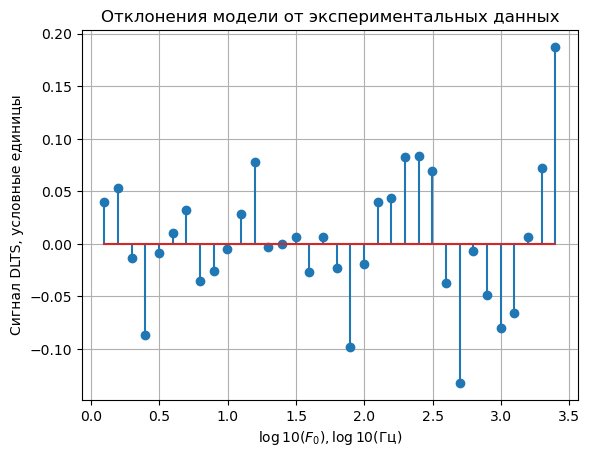

In [69]:
plot_deviations(X_train, y_train, y_pred)
plt.show()

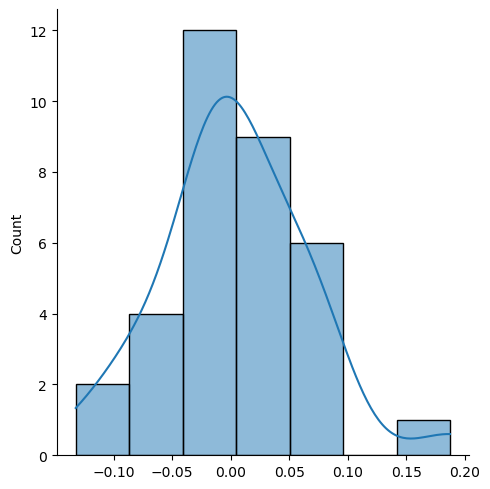

In [70]:
sns.displot(x=y_train - y_pred, bins=7, kde=True)
plt.show()

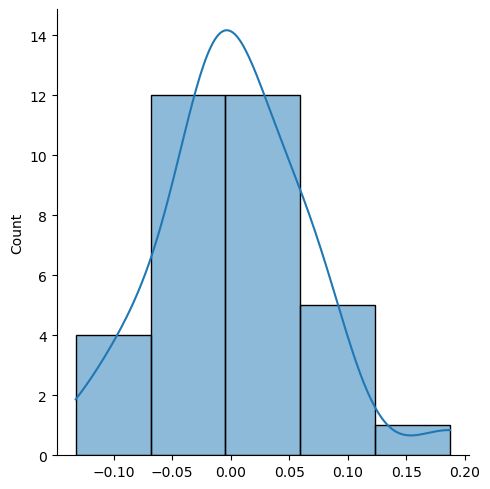

In [71]:
sns.displot(x=y_train - y_pred, bins=5, kde=True)
plt.show()

In [72]:
exps_params_283 = grid_search.best_estimator_.exps_params_
exps_params_283[:, 1] = exps_params_303[:, 1] / k

In [73]:
mean_squared_error(y_train, y_pred, squared=False)

0.06135722120421641

## 4. 1564ЛЕ1№1\_п1\_2500Гц-1Гц\_1пФ\_-10С\_-4В-5В\_10мВ\_10мкс\_шаг\_0,01.csv
### 4.1. Подготовка экспериментальных данных

In [74]:
filling_pulse, X_train, y_train = get_X_y(data_frames[2][1])

In [75]:
k, y_train = normalize(X_train, y_train)
k

5098.184559147843

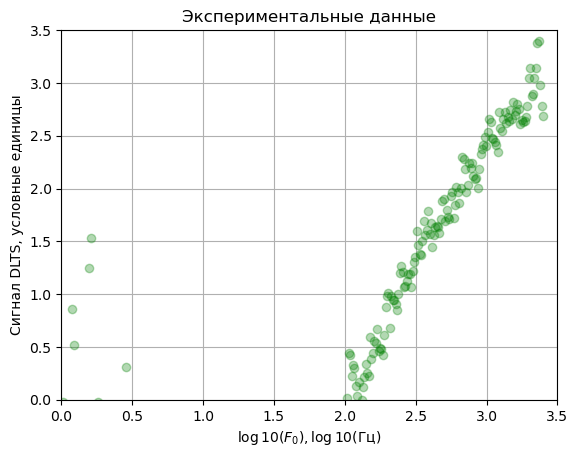

In [76]:
fig, ax = plot_experimental_points(X_train, y_train)
ax.set_ylim([0, 3.5])
ax.set_xlim([0, 3.5])
plt.show()

### 4.2. Идентификация моноэкспоненциальной модели с показателем $p$

In [77]:
monoexp_fs = SklSingleExpFrequencyScan(filling_pulse = filling_pulse,
                                       learning_rate = 0.05,
                                       stop_val = 10**-5,
                                       verbose = False
                                      )

monoexp_fs.fit(X = X_train, y = y_train)
monoexp_fs.fit_results_

,amplitude_0,filling_pulse,fit_p_coef,learning_rate,loss,n_exps,n_iters,p_coef,stop_val,time_constant_pow_0,verbose
0,-0.006116,0.00001,True,0.05,3.672730,1,1000,1.000000,0.00001,-1.918208,False
1,-0.034933,0.00001,True,0.05,3.656317,1,1000,1.000002,0.00001,-1.917747,False
2,-0.063023,0.00001,True,0.05,3.640495,1,1000,1.000023,0.00001,-1.915118,False
3,-0.090568,0.00001,True,0.05,3.624877,1,1000,1.000070,0.00001,-1.910384,False
4,-0.117741,0.00001,True,0.05,3.609114,1,1000,1.000148,0.00001,-1.903604,False
...,...,...,...,...,...,...,...,...,...,...,...
210,-2.440990,0.00001,True,0.05,2.126404,1,1000,1.051134,0.00001,-1.041995,False
211,-2.441677,0.00001,True,0.05,2.126392,1,1000,1.051433,0.00001,-1.042044,False
212,-2.442351,0.00001,True,0.05,2.126382,1,1000,1.051727,0.00001,-1.042091,False
213,-2.443012,0.00001,True,0.05,2.126371,1,1000,1.052015,0.00001,-1.042137,False


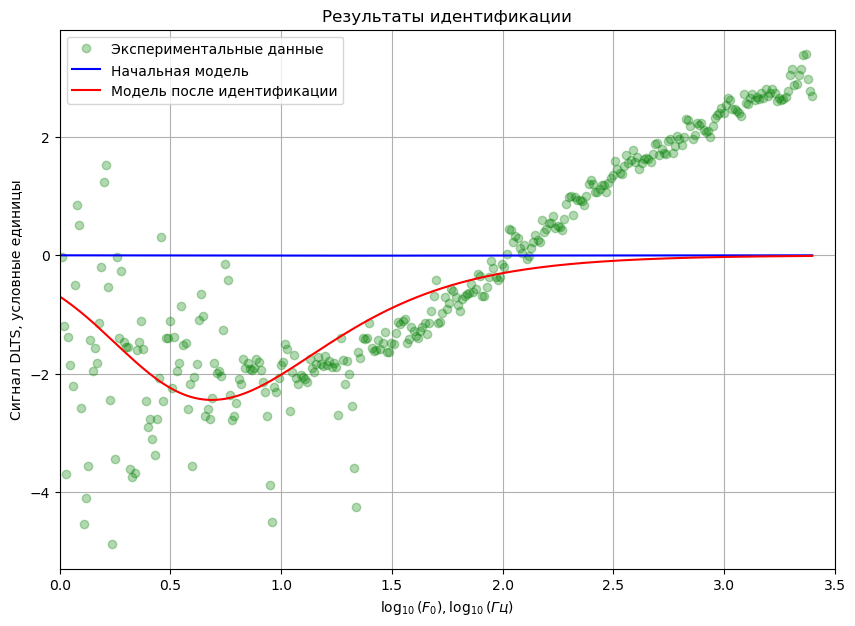

In [78]:
fig, ax = plot_model(X_train, y_train, SklSingleExpFrequencyScan, monoexp_fs.fit_results_, plot_exps=False)
plt.show()

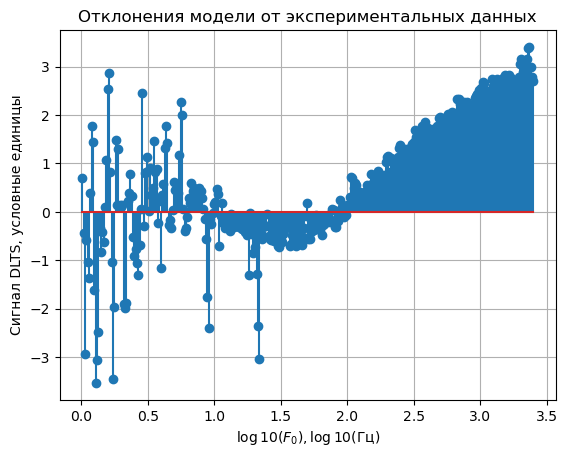

In [79]:
plot_deviations(X_train, y_train, monoexp_fs.predict(X_train))
plt.show()

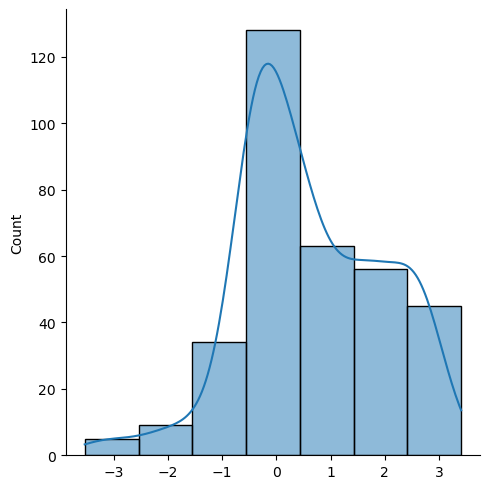

In [80]:
sns.displot(x=y_train - monoexp_fs.predict(X_train), bins=7, kde=True)
plt.show()

In [81]:
mean_squared_error(y_train, y_train - monoexp_fs.predict(X_train), squared=False)

1.2323968657423319

### 4.3. Идентификация мультиэкспоненциальной модели с n_exps=1

In [82]:
multiexp_fs = SklMultiExpFrequencyScan(n_exps = 1,
                                       filling_pulse = filling_pulse,
                                       stop_val = 10**-5,
                                       learning_rate=0.05,
                                      )

multiexp_fs.fit(X=X_train, y=y_train)

SklMultiExpFrequencyScan(filling_pulse=9.999999999999999e-06,
                         learning_rate=0.05, stop_val=1e-05)

In [83]:
multiexp_fs.fit_results_

,amplitude_0,filling_pulse,learning_rate,loss,n_exps,n_iters,stop_val,time_constant_pow_0,verbose
0,0.599307,0.00001,0.05,4.402077,1,1000,0.00001,-1.535466,False
1,0.530827,0.00001,0.05,4.295718,1,1000,0.00001,-1.563020,False
2,0.465459,0.00001,0.05,4.199498,1,1000,0.00001,-1.588763,False
3,0.403098,0.00001,0.05,4.112867,1,1000,0.00001,-1.612413,False
4,0.343612,0.00001,0.05,4.035147,1,1000,0.00001,-1.633738,False
...,...,...,...,...,...,...,...,...,...
184,-2.406524,0.00001,0.05,2.128411,1,1000,0.00001,-1.032983,False
185,-2.407294,0.00001,0.05,2.128400,1,1000,0.00001,-1.032967,False
186,-2.408043,0.00001,0.05,2.128389,1,1000,0.00001,-1.032951,False
187,-2.408773,0.00001,0.05,2.128378,1,1000,0.00001,-1.032936,False


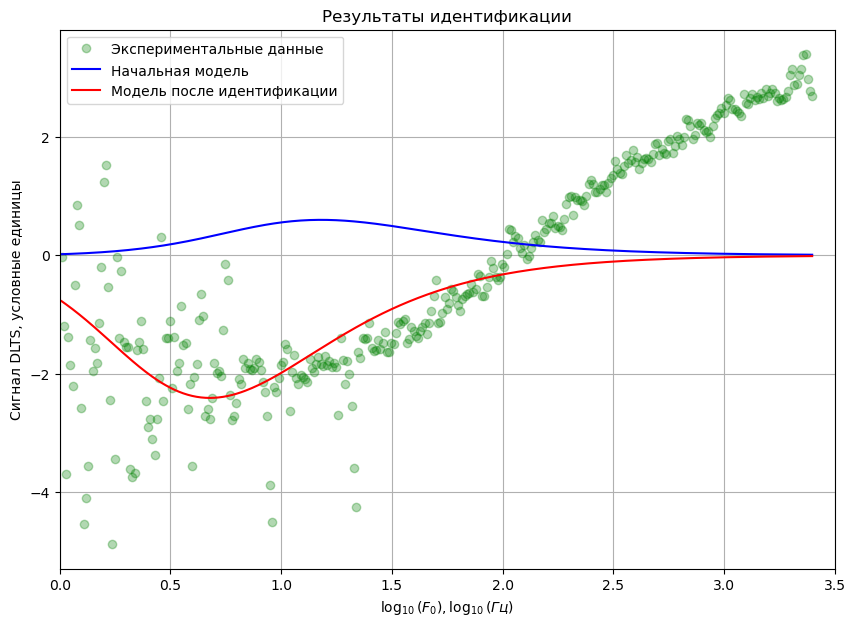

In [84]:
fig, ax = plot_model(X_train, y_train, SklMultiExpFrequencyScan, multiexp_fs.fit_results_, plot_exps=False)
plt.show()

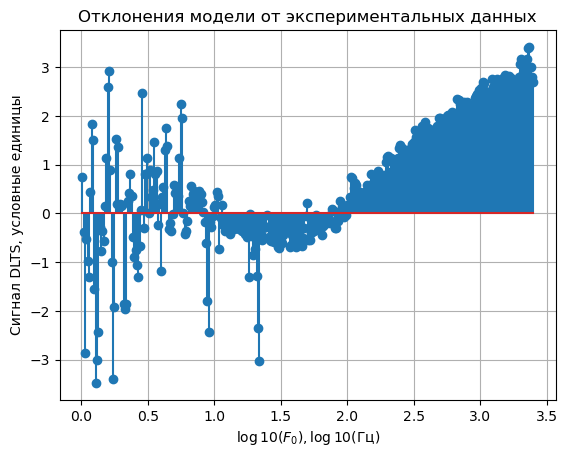

In [85]:
plot_deviations(X_train, y_train, multiexp_fs.predict(X_train))
plt.show()

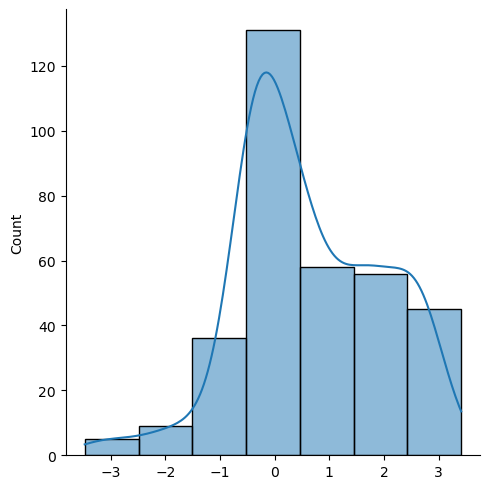

In [86]:
sns.displot(x=y_train - multiexp_fs.predict(X_train), bins=7, kde=True)
plt.show()

In [87]:
scores = cross_val_score(multiexp_fs, X_train, y_train, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
display_scores(np.sqrt(-scores))

2022-09-23 21:35:35.056623: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-09-23 21:35:35.056645: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: aleksei-B550I
2022-09-23 21:35:35.056649: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: aleksei-B550I
2022-09-23 21:35:35.056750: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-09-23 21:35:35.056762: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-09-23 21:35:35.056766: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.65.1
2022-09-23 21:35:35.056876: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instru

Scores: [2.1074304  1.27560227 2.21336004]
Mean: 1.8654642323370705
Standard deviation: 0.41933131403191604


In [88]:
mean_squared_error(y_train, multiexp_fs.predict(X_train), squared=False)

1.4588927537915102

### 4.4. Идентификация мультиэкспоненциальной модели с n_exps>1

In [89]:
multiexp_fs = SklMultiExpFrequencyScan(n_exps = 1,
                                       filling_pulse = filling_pulse,
                                       learning_rate = 0.05,
                                       stop_val = 10**-5
                                      )

In [90]:
param_grid = {'n_exps': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
grid_search = GridSearchCV(multiexp_fs, param_grid, cv=3, 
                           scoring='neg_mean_squared_error',
                           return_train_score=True, n_jobs=-1)

In [91]:
grid_search.fit(X_train, y_train)

2022-09-23 21:36:01.934397: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-09-23 21:36:01.934444: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: aleksei-B550I
2022-09-23 21:36:01.934452: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: aleksei-B550I
2022-09-23 21:36:01.934689: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-09-23 21:36:01.934722: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-09-23 21:36:01.934729: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.65.1
2022-09-23 21:36:01.934963: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instru

GridSearchCV(cv=3,
             estimator=SklMultiExpFrequencyScan(filling_pulse=9.999999999999999e-06,
                                                learning_rate=0.05,
                                                stop_val=1e-05),
             n_jobs=-1, param_grid={'n_exps': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [92]:
grid_search.best_params_

{'n_exps': 7}

In [93]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

1.614179256855717 {'n_exps': 1}
1.537139525666922 {'n_exps': 2}
1.4265031083991018 {'n_exps': 3}
1.3814241021131823 {'n_exps': 4}
1.3989791426898404 {'n_exps': 5}
1.3670462849679907 {'n_exps': 6}
1.2741236175734705 {'n_exps': 7}
1.336130995936526 {'n_exps': 8}
1.3314991579369624 {'n_exps': 9}
1.4242209266899177 {'n_exps': 10}


In [94]:
y_pred = grid_search.best_estimator_.predict(X_train)

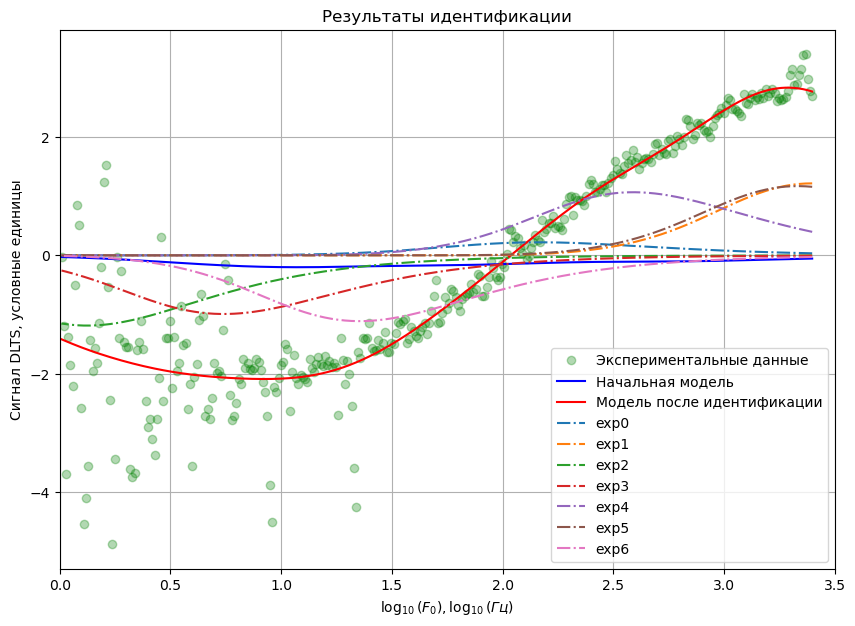

In [96]:
fig, ax = plot_model(X_train, y_train, SklMultiExpFrequencyScan, grid_search.best_estimator_.fit_results_)
plt.show()

In [97]:
grid_search.best_estimator_.fit_results_

,amplitude_0,amplitude_1,amplitude_2,amplitude_3,amplitude_4,amplitude_5,amplitude_6,filling_pulse,learning_rate,loss,...,n_iters,stop_val,time_constant_pow_0,time_constant_pow_1,time_constant_pow_2,time_constant_pow_3,time_constant_pow_4,time_constant_pow_5,time_constant_pow_6,verbose
0,-0.138213,-0.051363,-0.044678,-0.086227,0.082510,-0.037393,-0.080509,0.00001,0.05,3.533727,...,1000,0.00001,-2.472090,-3.284579,-1.002119,-1.294327,-2.753013,-3.149289,-1.565385,False
1,-0.116591,0.007303,-0.102683,-0.140926,0.124073,0.020315,-0.125176,0.00001,0.05,3.195085,...,1000,0.00001,-2.461266,-3.284787,-1.002248,-1.292171,-2.758050,-3.148708,-1.561457,False
2,-0.097824,0.062465,-0.157265,-0.192286,0.162735,0.074340,-0.167308,0.00001,0.05,2.897103,...,1000,0.00001,-2.452670,-3.284771,-1.002437,-1.288863,-2.765206,-3.149039,-1.555840,False
3,-0.081490,0.114360,-0.208601,-0.240504,0.198821,0.124953,-0.207088,0.00001,0.05,2.634068,...,1000,0.00001,-2.445891,-3.284743,-1.002569,-1.284640,-2.774059,-3.150295,-1.548960,False
4,-0.067248,0.163196,-0.256851,-0.285754,0.232592,0.172394,-0.244657,0.00001,0.05,2.401402,...,1000,0.00001,-2.440593,-3.284874,-1.002554,-1.279709,-2.784246,-3.152455,-1.541185,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376,0.219298,1.215007,-1.186442,-0.991647,1.064867,1.168874,-1.111105,0.00001,0.05,0.447109,...,1000,0.00001,-2.523285,-3.778035,-0.479986,-1.094818,-2.949612,-3.710732,-1.709019,False
377,0.219450,1.215184,-1.186661,-0.991603,1.065201,1.169037,-1.111375,0.00001,0.05,0.447099,...,1000,0.00001,-2.523416,-3.778289,-0.479749,-1.094791,-2.949650,-3.710949,-1.709041,False
378,0.219601,1.215360,-1.186879,-0.991559,1.065534,1.169198,-1.111644,0.00001,0.05,0.447089,...,1000,0.00001,-2.523547,-3.778544,-0.479513,-1.094764,-2.949689,-3.711166,-1.709062,False
379,0.219751,1.215535,-1.187095,-0.991514,1.065867,1.169358,-1.111911,0.00001,0.05,0.447079,...,1000,0.00001,-2.523677,-3.778797,-0.479278,-1.094737,-2.949730,-3.711381,-1.709082,False


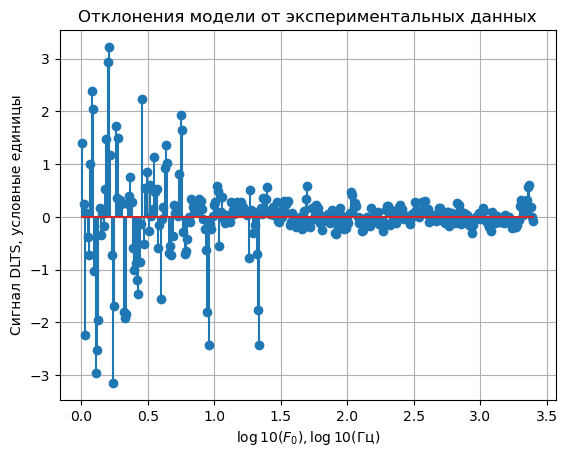

In [98]:
plot_deviations(X_train, y_train, y_pred)
plt.show()

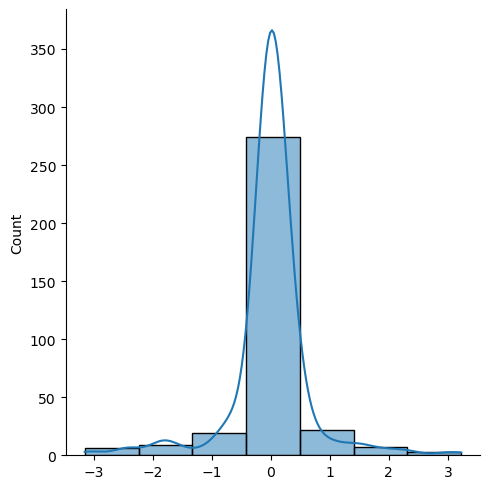

In [99]:
sns.displot(x=y_train - y_pred, bins=7, kde=True)
plt.show()

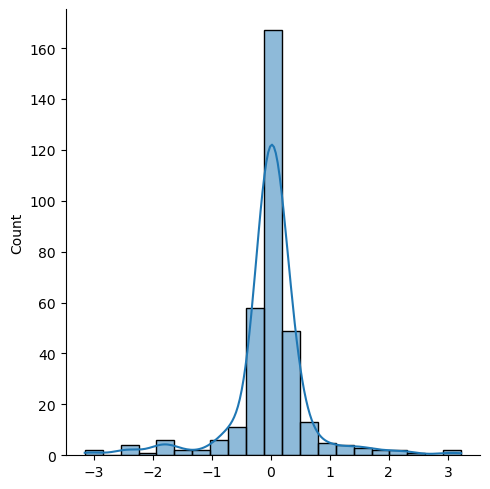

In [101]:
sns.displot(x=y_train - y_pred, bins=21, kde=True)
plt.show()

In [103]:
exps_params_263 = grid_search.best_estimator_.exps_params_
exps_params_263[:, 1] = exps_params_303[:, 1] / k